[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/08d_AlexNet.ipynb)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
sns.set_theme()

2023-07-02 15:21:18.170571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

2023-07-02 15:21:19.759255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:21:19.762660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:21:19.762793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras.regularizers import l2

In [4]:
def create_AlexNet_like(input_shape=[32, 32, 3], num_classes=10, activation="relu", pooling_layer=layers.MaxPooling2D, batch_normalization=True, kernel_regularizer=l2(5e-4)):
    """Create a keras sequencial model based on the AlexNet architecture"""

    base_filters = 32

    model = Sequential()
    
    model.add(layers.Conv2D(filters=base_filters, kernel_size=3, strides=1, activation=activation, padding="same", input_shape=input_shape, kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=base_filters, kernel_size=3, strides=1, activation=activation, padding="same", input_shape=input_shape, kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(pooling_layer(pool_size=2, strides=2, padding="valid"))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(filters=base_filters*2, kernel_size=3, strides=1, activation=activation, padding="same", input_shape=input_shape, kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=base_filters*2, kernel_size=3, strides=1, activation=activation, padding="same", input_shape=input_shape, kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(pooling_layer(pool_size=2, strides=2, padding="valid"))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filters=base_filters*4, kernel_size=3, strides=1, activation=activation, padding="same", input_shape=input_shape, kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=base_filters*4, kernel_size=3, strides=1, activation=activation, padding="same", input_shape=input_shape, kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(pooling_layer(pool_size=2, strides=2, padding="valid"))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())    
    model.add(layers.Dense(units=num_classes, activation="softmax"))

    return model

In [5]:
num_classes = 10


model = create_AlexNet_like()

model.summary()

2023-07-02 15:21:19.804164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:21:19.804323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 15:21:19.804421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [6]:
# Data loading and preprocessing

(train_data, validation_data), info = tfds.load('cifar10', split=["train", "test"], with_info=True, as_supervised=True)

In [7]:
def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)


# initiliaze the color normalization layer
normalization_layer = layers.Normalization(axis=None)
normalization_layer.adapt(train_data.map(normalize).map(lambda x, y: x))


def pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    dataset = dataset.map(to_categorical)
    dataset = dataset.cache()
    dataset = dataset.shuffle(info.splits['train'].num_examples)
    return dataset

processed_train_data = pipeline(train_data)
processed_validation_data = pipeline(validation_data)

batch_size = 64

batched_train_data = processed_train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_validation_data = processed_validation_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

2023-07-02 15:21:20.725187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-02 15:21:20.725420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [8]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom((-0.2, 0.2)),
  layers.RandomTranslation(
    (-0.1, 0.1), (-0.1, 0.1)
  ),
  layers.RandomRotation(0.2),
])

In [9]:
batched_train_data = batched_train_data.map(lambda x, y: (data_augmentation(x), y))

2023-07-02 15:21:42.252303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 15:21:42.252682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_43' with dtype resource
	 [[{{node Placeholder/_43}}]]


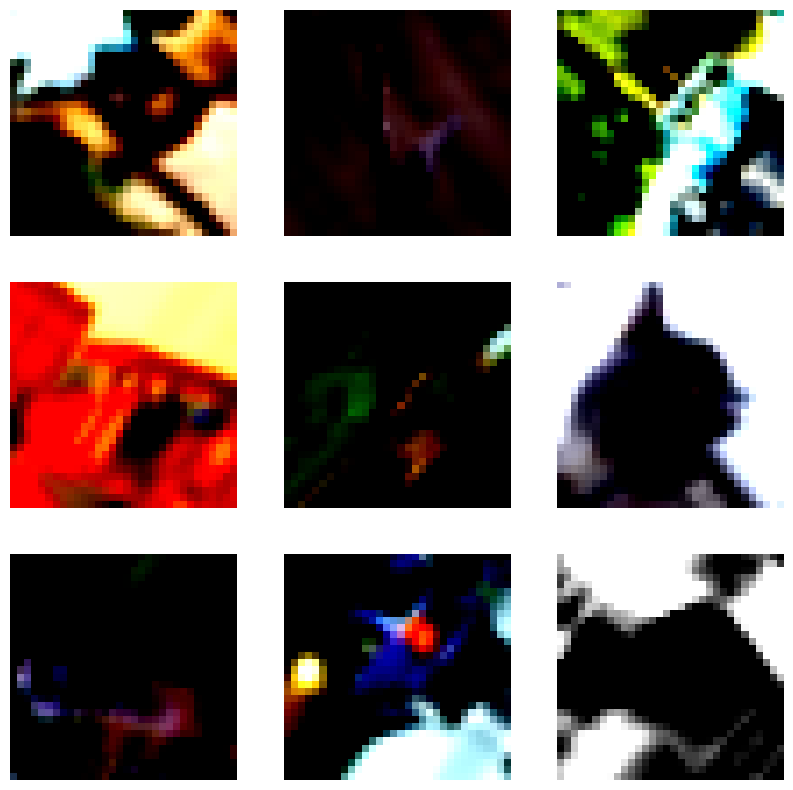

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in batched_train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

In [11]:
lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=np.sqrt(0.1))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [12]:
history = model.fit(
    batched_train_data,
    epochs=125,
    validation_data=batched_validation_data,
    callbacks=[lr_reducer]
)

Epoch 1/125


2023-07-02 15:21:43.285745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_43' with dtype resource
	 [[{{node Placeholder/_43}}]]
2023-07-02 15:21:43.286133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_44' with dtype resource
	 [[{{node Placeholder/_44}}]]
2023-07-02 15:21:43.955823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-02 15:21:44.674495: I tensorflow/compiler/xla/stream_executor/cu

782/782 [==============================] - ETA: 0s - loss: 2.7118 - accuracy: 0.3022

2023-07-02 15:21:54.168923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 15:21:54.169315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


782/782 [==============================] - 11s 11ms/step - loss: 2.7118 - accuracy: 0.3022 - val_loss: 1.8867 - val_accuracy: 0.4046 - lr: 0.0100
Epoch 2/125
782/782 [==============================] - 8s 10ms/step - loss: 1.8956 - accuracy: 0.3858 - val_loss: 1.7258 - val_accuracy: 0.4470 - lr: 0.0100
Epoch 3/125
782/782 [==============================] - 8s 10ms/step - loss: 1.7974 - accuracy: 0.4172 - val_loss: 1.7971 - val_accuracy: 0.4323 - lr: 0.0100
Epoch 4/125
782/782 [==============================] - 8s 10ms/step - loss: 1.7081 - accuracy: 0.4455 - val_loss: 1.5398 - val_accuracy: 0.4975 - lr: 0.0100
Epoch 5/125
782/782 [==============================] - 8s 10ms/step - loss: 1.6339 - accuracy: 0.4663 - val_loss: 1.6447 - val_accuracy: 0.4845 - lr: 0.0100
Epoch 6/125
782/782 [==============================] - 8s 11ms/step - loss: 1.5512 - accuracy: 0.4956 - val_loss: 1.6305 - val_accuracy: 0.4963 - lr: 0.0100
Epoch 7/125
782/782 [==============================] - 8s 10ms/step -

<Axes: >

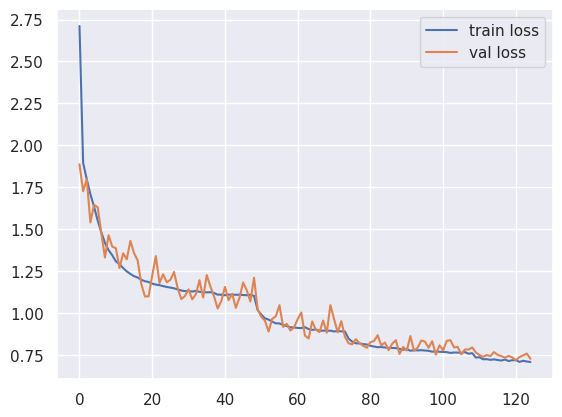

In [13]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")

<Axes: >

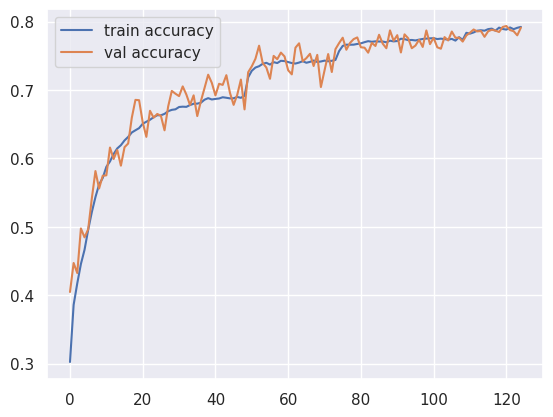

In [14]:
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label="train accuracy")
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label="val accuracy")